In [1]:
import plumed
import numpy as np
import pandas as pd
import MDAnalysis as mda
import nglview
import os
from pathlib import Path
from psfgen import PsfGen
import subprocess
import gromacs
import panedr
from gromacs.setup import *

import matplotlib.pyplot as plt

import yaml



--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------


In [2]:
base  = Path(os.getcwd()).parent

In [3]:
import sys
extra_path = str(base / 'src' )

In [4]:
if extra_path not in sys.path:
    sys.path.append(extra_path)
    
from utils import clean, run_omp_slurm, run_mpi_slurm

In [5]:
# set some general constants
NSTEPS = 5000000
NSTXOUT = 100
TEMPERATURE = 340
NSTENERGY=100

# set timers to strech and posres runs

nsteps_strech = 100000
nsteps_posres = 100000


# YYDPETGTWY -> GYDPETGTWG
# set some mutation and file/folder names 

mutate = []

mutate_name = 'YYDPETGTWY'

NTHREADS = 32


In [6]:
fdir = base / 'data/interim' / mutate_name /'state_folded'
ufdir = base / 'data/interim' / mutate_name /'state_unfolded'

In [7]:
# run wtmetad
system = dict()

system['srun_args'] = ['-p mig', '-G1', '-N1', '--tasks-per-node=1', '--cpus-per-task=2', '--mpi=pmix', '--hint=nomultithread', '--contiguous' ]
system['singularity_args'] = ['--nv', '--cleanenv', '--home $(pwd)', '--env GMX_CUDA_GRAPH=1', '--env GMX_ENABLE_DIRECT_GPU_COMM=1']
system['docker_filename']= '~/gromacs_2023-2.sif'
system['mpirun_args'] = ['-n 1',  ' -bind-to core:2']

In [8]:
system

{'srun_args': ['-p mig',
  '-G1',
  '-N1',
  '--tasks-per-node=1',
  '--cpus-per-task=2',
  '--mpi=pmix',
  '--hint=nomultithread',
  '--contiguous'],
 'singularity_args': ['--nv',
  '--cleanenv',
  '--home $(pwd)',
  '--env GMX_CUDA_GRAPH=1',
  '--env GMX_ENABLE_DIRECT_GPU_COMM=1'],
 'docker_filename': '~/gromacs_2023-2.sif',
 'mpirun_args': ['-n 1', ' -bind-to core:2']}

# Calculate HLDA CV

## Let's see the states first

In [9]:
from harmonic_discriminant_analysis import HarmonicLinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

In [10]:
data = pd.concat([
    (plumed.read_as_pandas(str(fdir / 'MD/COLVAR'))).assign(state = 'folded'),
    (plumed.read_as_pandas(str(ufdir / 'MD/COLVAR'))).assign(state = 'unfolded')]).reset_index(drop=True)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/3529124963.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (plumed.read_as_pandas(str(fdir / 'MD/COLVAR'))).assign(state = 'folded'),
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/3529124963.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  (plumed.read_as_pandas(str(ufdir / 'MD/COLVAR'))).assign(state = 'unfolded')]).reset_index(drop=True)


## Plot before calculating HLDA

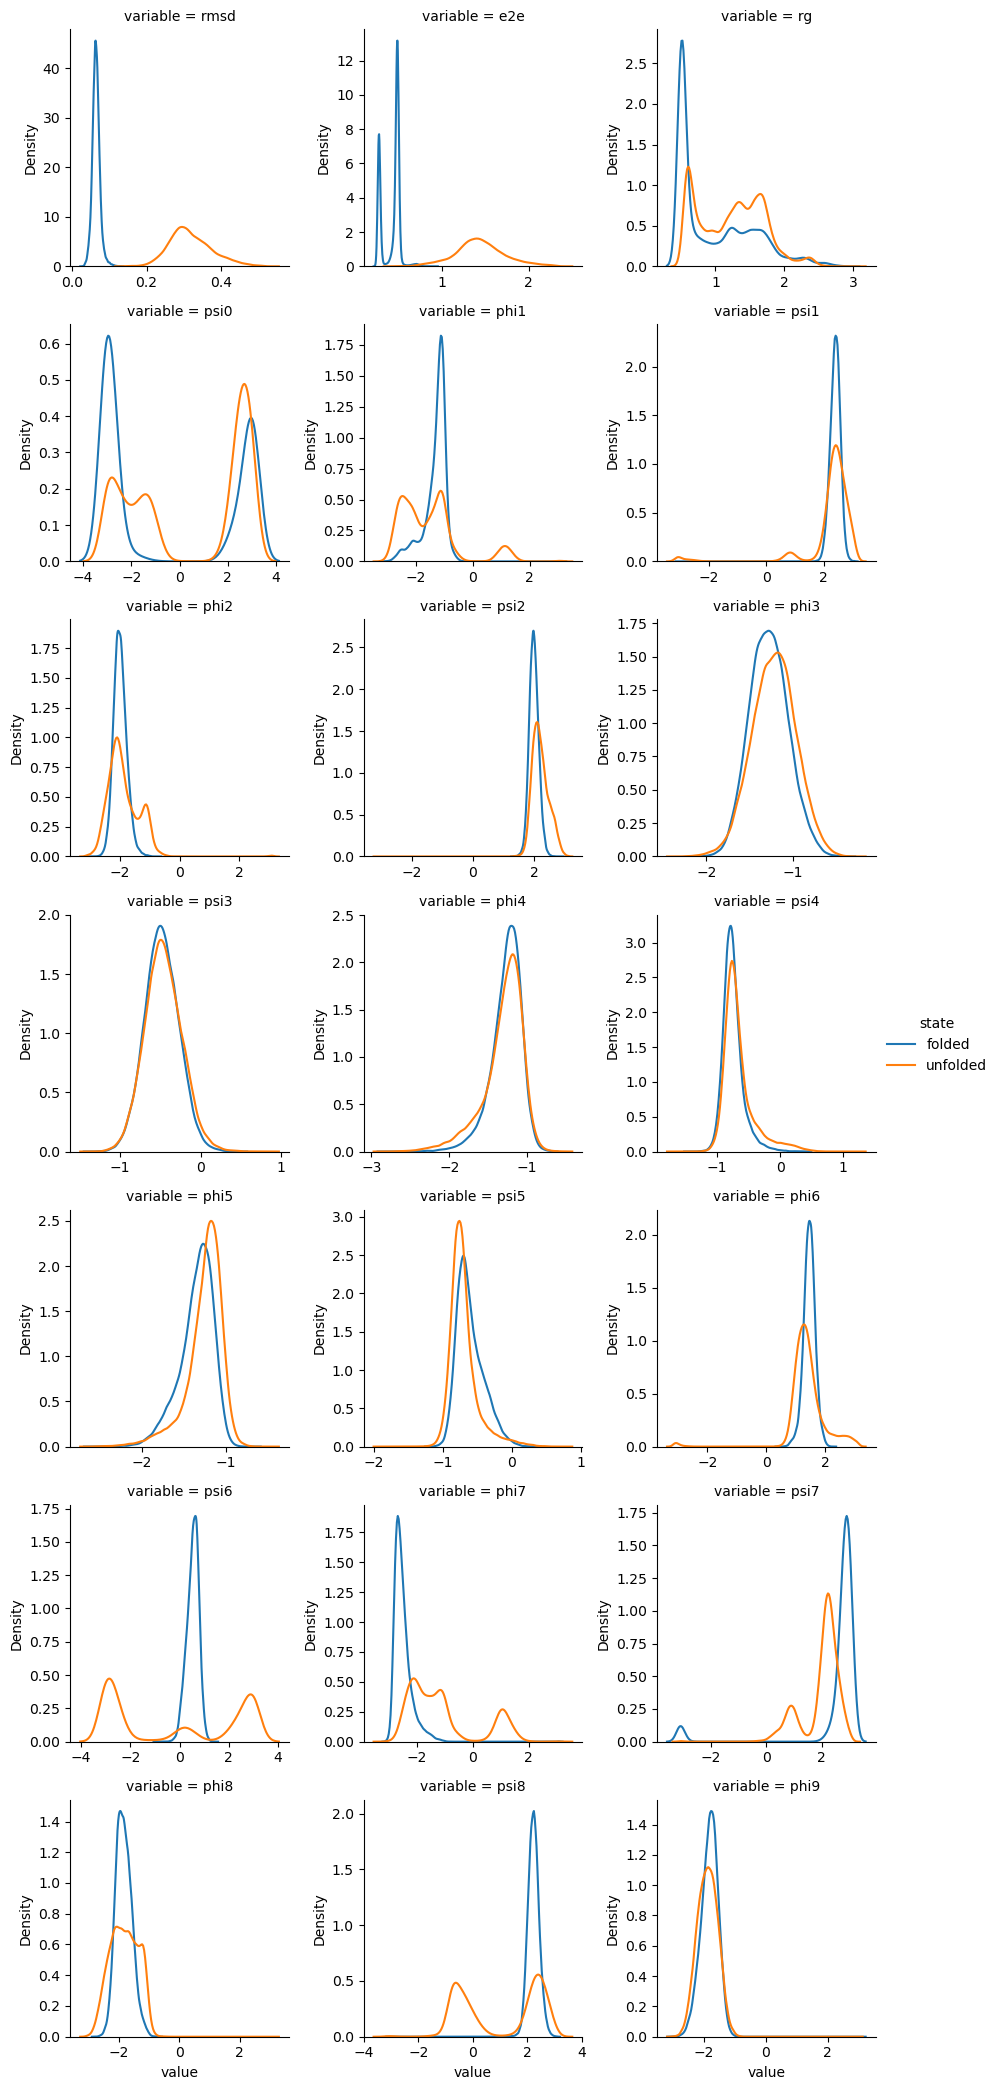

In [11]:
g = sns.FacetGrid(data.melt(id_vars=['time','state']),col='variable', hue='state', col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot,'value' )
g.add_legend()

<Axes: xlabel='time'>

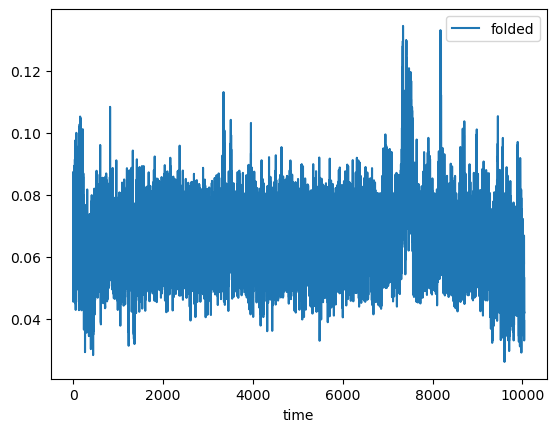

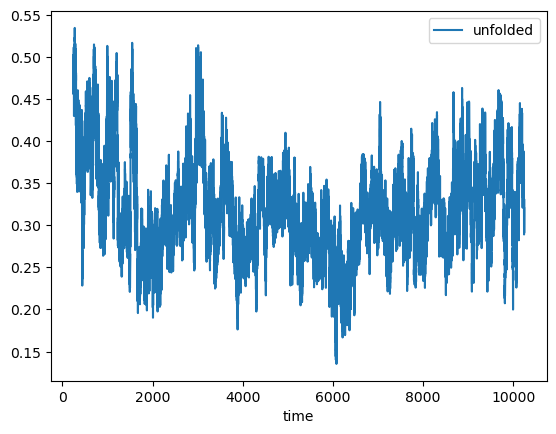

In [12]:
data[data.state == 'folded'].plot('time','rmsd', label = 'folded')
data[data.state == 'unfolded'].plot('time','rmsd', label = 'unfolded')

<Axes: xlabel='time'>

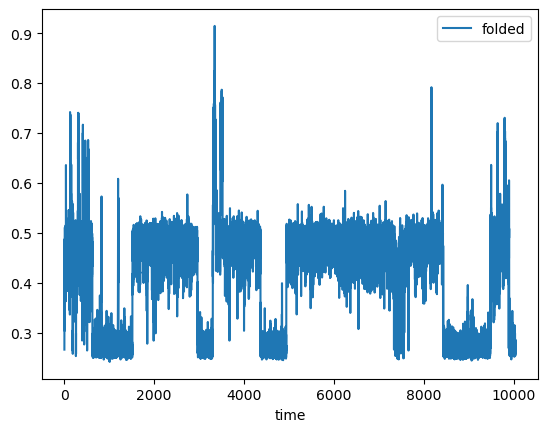

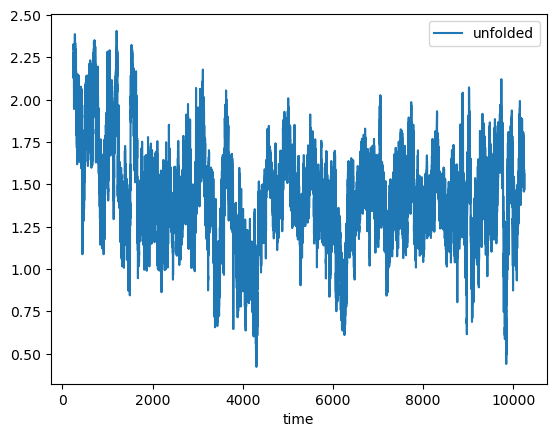

In [13]:
data[data.state == 'folded'].plot('time','e2e', label = 'folded')
data[data.state == 'unfolded'].plot('time','e2e', label = 'unfolded')

<Axes: xlabel='e2e', ylabel='rmsd'>

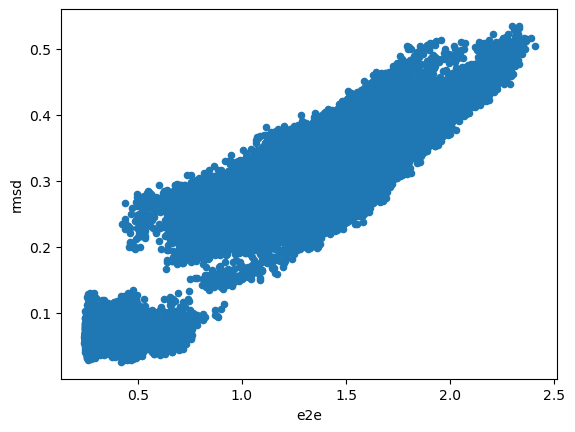

In [14]:
data.plot('e2e','rmsd', kind='scatter')

In [15]:
X = data.iloc[:,data.columns.str.contains('^p')].copy(deep=True)
y = data.state

# apply unwrap 
X = X.apply(np.unwrap,)


In [16]:
hlda = HarmonicLinearDiscriminantAnalysis()

In [17]:
hlda.fit(X,y)

HarmonicLinearDiscriminantAnalysis()

## Plot State separation

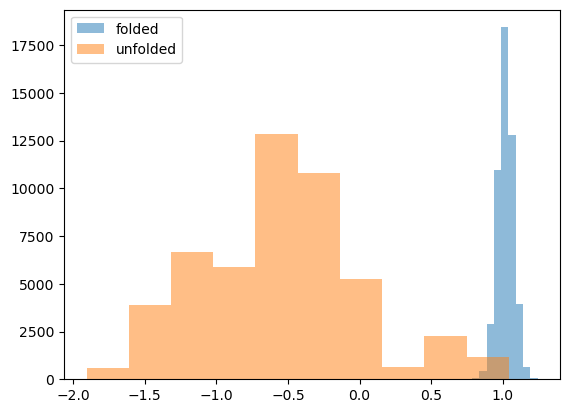

In [18]:
plt.hist(hlda.transform(X)[y == 'folded'],  label = 'folded', alpha=0.5 )
plt.hist(hlda.transform(X)[y == 'unfolded'], label = 'unfolded', alpha =  0.5)
plt.legend()
plt.show()

__Separation is not good, We will filter the data and  recalculate__

In [19]:
hlda_evects = (hlda.scalings_)[:,0]

## Plot HLDA coefficients

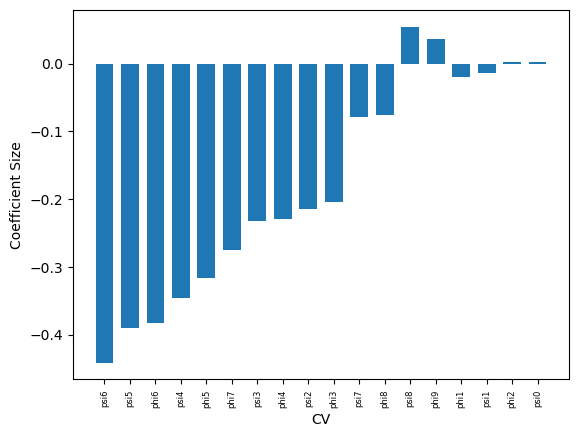

In [20]:
fig = plt.figure()
sortx = np.argsort(np.abs(hlda_evects.flatten()),)[::-1]
plt.bar(X.columns[sortx],hlda_evects.flatten()[sortx],align='center', width=0.7)
plt.xticks(rotation=90,fontsize=6)
plt.xlabel('CV')
plt.ylabel('Coefficient Size')
plt.show()

## Filter only non overlapping states

__We can see _phi6_ descriminates between the states nicely, let's cutoff using its values__

In [21]:

data_filter = pd.concat([
    data.query("state == 'folded' and psi6 < 2.0 and psi6 > -1.0"),
    data.query("state == 'unfolded' and (psi6 >= 2.0 or psi6 <= -1.0)")
])

In [22]:
X = data_filter.iloc[:,data_filter.columns.str.contains('^p')].copy(deep=True)
y = data_filter.state

In [23]:
# apply unwrap since these are angles, we need to make shure they are continoues for the HLDA algorithem.
X = X.apply(np.unwrap,)

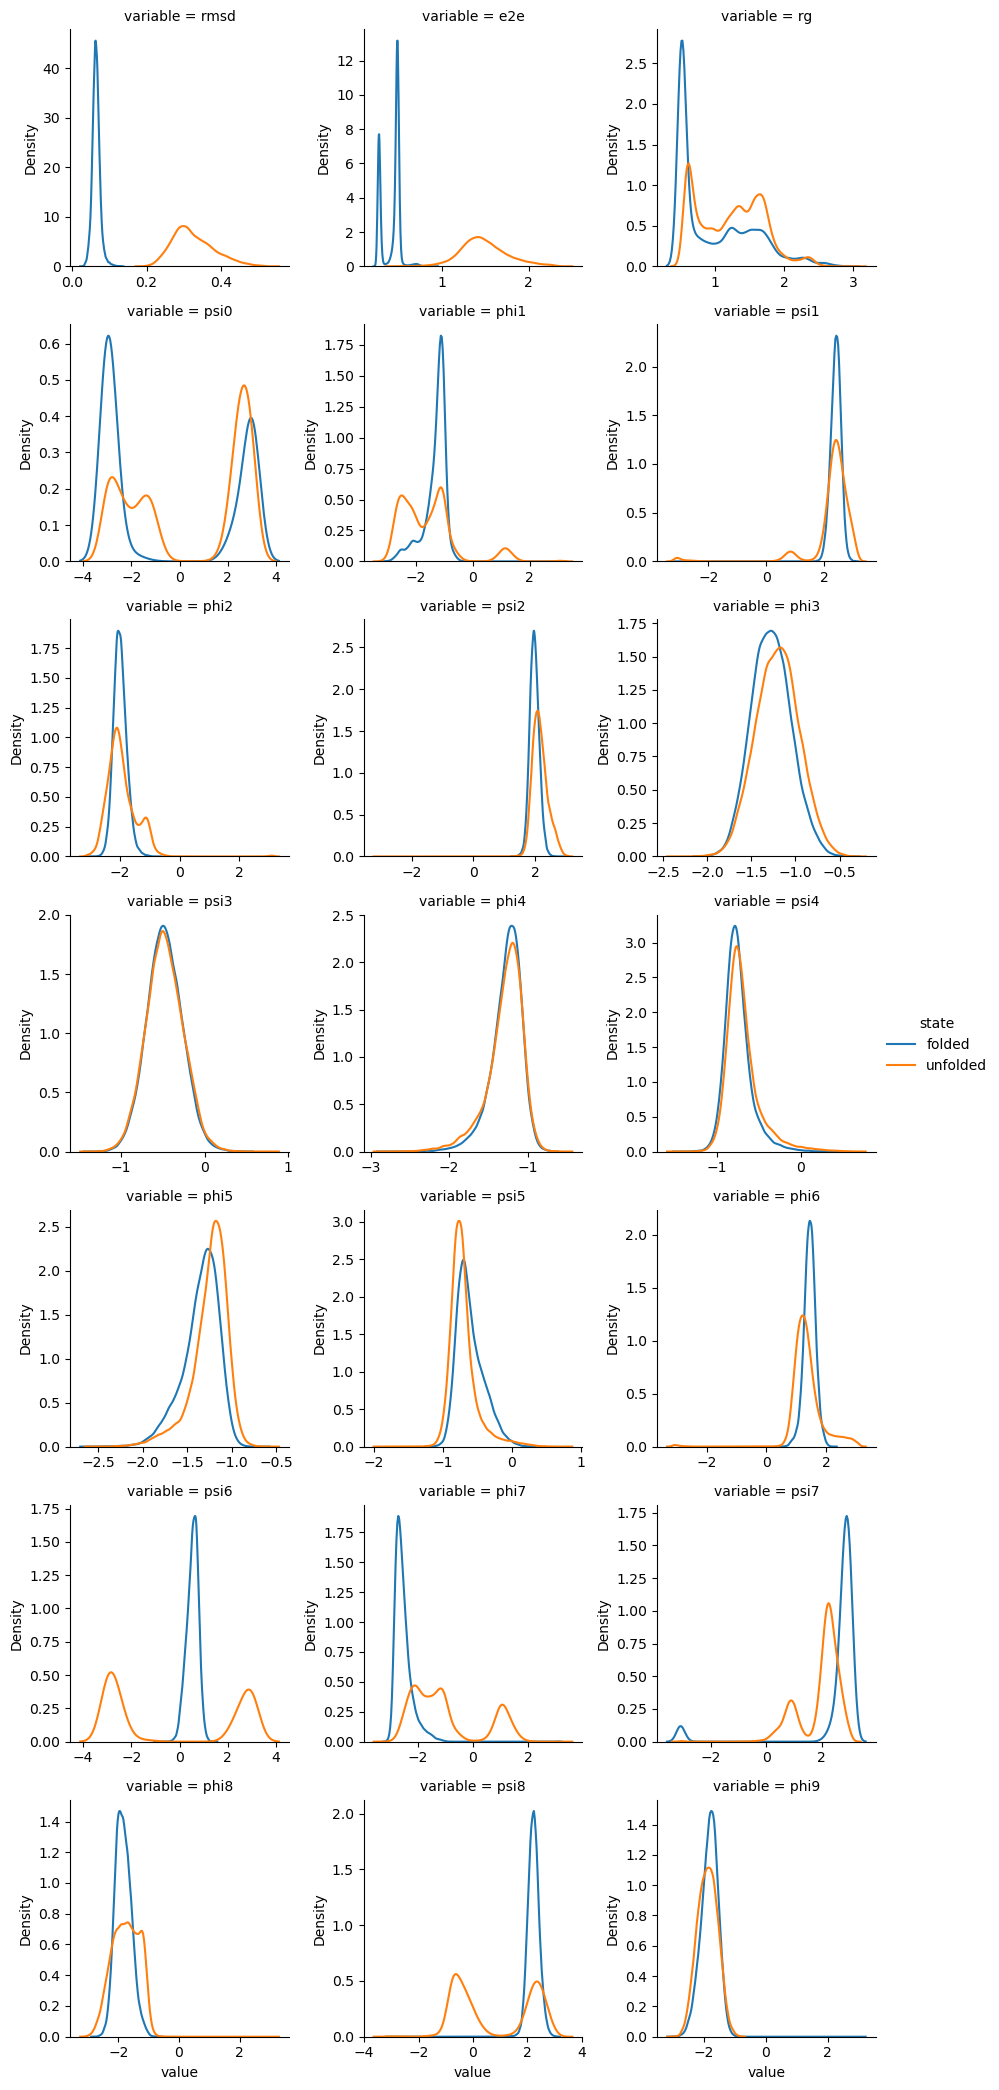

In [24]:
g = sns.FacetGrid(data_filter.melt(id_vars=['time','state']),col='variable', hue='state', col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot,'value' )
g.add_legend()

In [25]:
hlda.fit(X,y)

HarmonicLinearDiscriminantAnalysis()

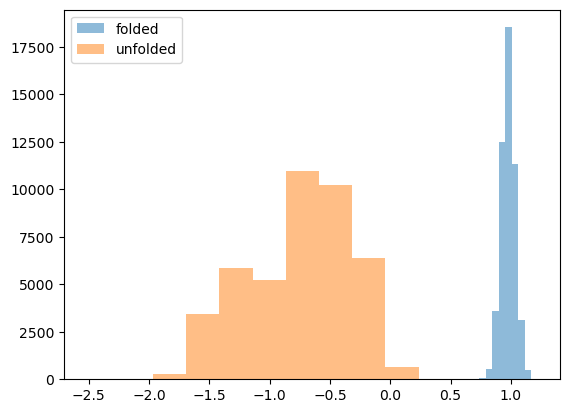

In [26]:
plt.hist(hlda.transform(X)[y == 'folded'],  label = 'folded', alpha=0.5 )
plt.hist(hlda.transform(X)[y == 'unfolded'], label = 'unfolded', alpha =  0.5)
plt.legend()
plt.show()

In [27]:
hlda_evects = (hlda.scalings_)[:,0]

## Plot HLDA coefficients

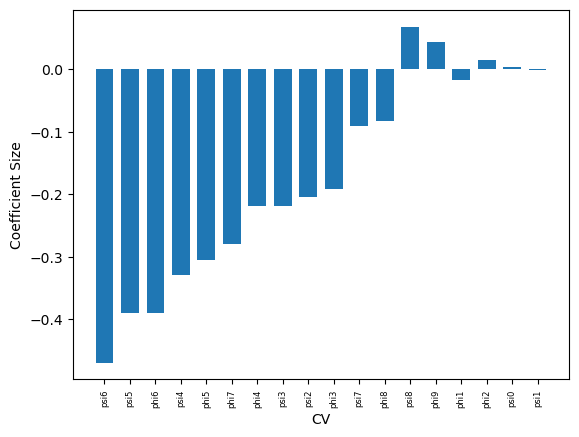

In [28]:
fig = plt.figure()
sortx = np.argsort(np.abs(hlda_evects.flatten()),)[::-1]
plt.bar(X.columns[sortx],hlda_evects.flatten()[sortx],align='center', width=0.7)
plt.xticks(rotation=90,fontsize=6)
plt.xlabel('CV')
plt.ylabel('Coefficient Size')
plt.show()

<Axes: xlabel='e2e', ylabel='rmsd'>

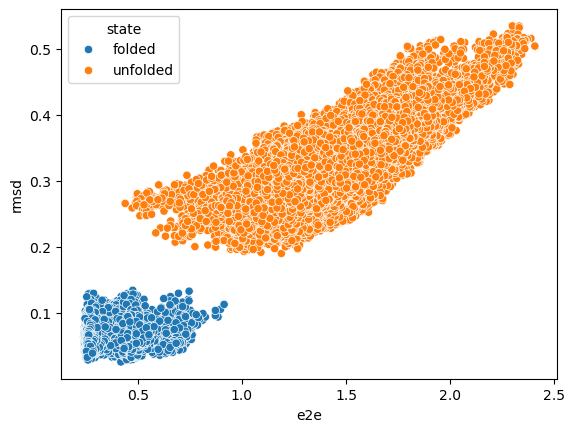

In [29]:
sns.scatterplot(data=data_filter, x='e2e', y='rmsd', hue='state')

<Axes: xlabel='e2e', ylabel='rmsd'>

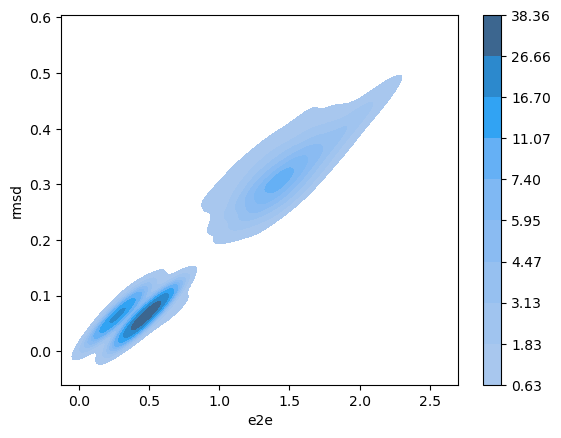

In [30]:
sns.kdeplot(
    data=data_filter.iloc[::10,:],
    x='e2e',
    y='rmsd',
    #hue='state',
    cbar=True,
    zorder=0,
    fill=True,
)

# Use Plumed to histogram unbiased runs on HLDA-CV  

In [54]:
os.makedirs(base / 'data/interim' / mutate_name / 'fes', exist_ok= True)
os.chdir(base / 'data/interim' / mutate_name / 'fes')

In [41]:
# concat trajectories from folded and unfolded run
gromacs.trjcat('cat', f=[str(fdir / 'MD/md.trr'), str(ufdir / 'MD/md.trr')], o='md_concat.trr')

--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------
                      :-) GROMACS - gmx trjcat, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov

KeyboardInterrupt: 

In [131]:
# copy ref file 
shutil.copy2(fdir / 'MD/reference.pdb', './')
        


'./reference.pdb'

In [55]:
# write plumed file to evaluate unbiased FES
with open('plumed_fes_unbiased.dat', 'w') as f:
    print("""
    # vim:ft=plumed
    # calculate  CVs for HLDA 
    MOLINFO STRUCTURE=reference.pdb MOLTYPE=protein
    WHOLEMOLECULES RESIDUES=all MOLTYPE=protein
    rmsd: RMSD REFERENCE=reference.pdb TYPE=OPTIMAL NOPBC
    e2e: DISTANCE ATOMS=@N-0,@O-9 NOPBC
    rg: GYRATION TYPE=RADIUS ATOMS=@back-0,@back-1,@back-2,@back-3,@back-4,@back-5,@back-6,@back-7,@back-8,@back-9 NOPBC

    # dihedrals
    psi0: TORSION ATOMS=@psi-0 NOPBC
    phi1: TORSION ATOMS=@phi-1 NOPBC
    psi1: TORSION ATOMS=@psi-1 NOPBC
    phi2: TORSION ATOMS=@phi-2 NOPBC
    psi2: TORSION ATOMS=@psi-2 NOPBC
    phi3: TORSION ATOMS=@phi-3 NOPBC
    psi3: TORSION ATOMS=@psi-3 NOPBC
    phi4: TORSION ATOMS=@phi-4 NOPBC
    psi4: TORSION ATOMS=@psi-4 NOPBC
    phi5: TORSION ATOMS=@phi-5 NOPBC
    psi5: TORSION ATOMS=@psi-5 NOPBC
    phi6: TORSION ATOMS=@phi-6 NOPBC
    psi6: TORSION ATOMS=@psi-6 NOPBC
    phi7: TORSION ATOMS=@phi-7 NOPBC
    psi7: TORSION ATOMS=@psi-7 NOPBC
    phi8: TORSION ATOMS=@phi-8 NOPBC
    psi8: TORSION ATOMS=@psi-8 NOPBC
    phi9: TORSION ATOMS=@phi-9 NOPBC

    # combine hlda cv
    COMBINE ...
    ARG={}
    COEFFICIENTS={} 
    PERIODIC=NO
    LABEL=comb1
    ... COMBINE

    # histogram over HLDA-CV

    hhh: HISTOGRAM ARG=comb1 STRIDE=1 GRID_MIN=-6.5 GRID_MAX=6.5 GRID_BIN=300 BANDWIDTH=0.3

    # convert to fes

    fff: CONVERT_TO_FES GRID=hhh TEMP=340 MINTOZERO

    # print
    DUMPGRID GRID=fff FILE=fes.dat 

    # histogram over e2e,rmsd

    hhr: HISTOGRAM ARG=e2e,rmsd STRIDE=1 GRID_MIN=0,0 GRID_MAX=5,1 GRID_BIN=300,300 KERNEL=DISCRETE 

    # convert to fes

    ffr: CONVERT_TO_FES GRID=hhr TEMP=340 MINTOZERO

    # print
    DUMPGRID GRID=ffr FILE=fes2.dat 

    
    

    PRINT ...
    ARG=comb1,rg,rmsd,e2e
    FILE=COLVAR STRIDE=1
    ... PRINT
    
    """.format(
        ','.join(X.columns),
        ','.join(['{:.4f}'.format(i) for i in hlda_evects])
    ), file = f) 

In [56]:
# run plumed driver
subprocess.run(
    'export  PLUMED_NUM_THREADS={} && plumed driver --plumed=plumed_fes_unbiased.dat --mf_trr=md_concat.trr'.format(NTHREADS)
               , shell=True )


--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------



DRIVER: Found molfile format trajectory trr with name md_concat.trr
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed
PLUMED: For installed feature, see /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 32
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 5094
PLUMED: File suffix: 
PLUMED: FILE: plumed_fes_unbiased.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named reference.pdb contains 1 chains 
PLUMED:   chain named A contains residues 0 to 9 and atoms 1 to 166 
PLUMED: Action WHOLEMOLECULES
PLUMED:   with label @1
PLUMED:   with stride 1
PLUMED: W

CompletedProcess(args='export  PLUMED_NUM_THREADS=32 && plumed driver --plumed=plumed_fes_unbiased.dat --mf_trr=md_concat.trr', returncode=0)

In [57]:
fes_unbiased = plumed.read_as_pandas('fes.dat')
fes2_unbiased = plumed.read_as_pandas('fes2.dat')
colvar_unbiased = plumed.read_as_pandas('COLVAR')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/2740764078.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fes_unbiased = plumed.read_as_pandas('fes.dat')
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/2740764078.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fes2_unbiased = plumed.read_as_pandas('fes2.dat')
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/2740764078.py:3: FutureWarning: The 'del

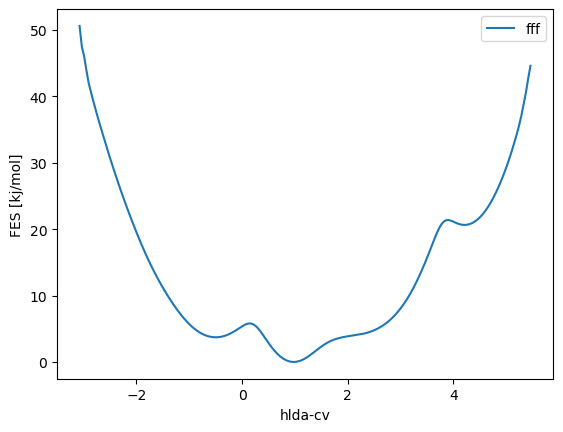

In [58]:
fes_unbiased.plot(x='comb1', y='fff')
plt.xlabel('hlda-cv')
plt.ylabel('FES [kj/mol]')
plt.show()

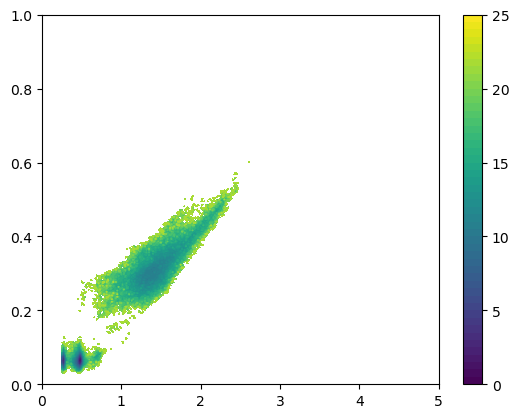

In [70]:
fig, ax = plt.subplots()
from matplotlib.cm import ScalarMappable
levels = 50
vmin = 0
vmax = 25
level_boundaries = np.linspace(vmin, vmax, levels + 1)

quadcontourset = ax.contourf(
    fes2_unbiased.e2e.to_numpy().reshape(301,301),
    fes2_unbiased.rmsd.to_numpy().reshape(301,301), 
    fes2_unbiased.ffr.to_numpy().reshape(301,301),
    level_boundaries,  # change this to `levels` to get the result that you want
    vmin=vmin, vmax=vmax
)


fig.colorbar(
    ScalarMappable(norm=quadcontourset.norm, cmap=quadcontourset.cmap),
    ticks=range(vmin, vmax+5, 5),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax
)


<Axes: xlabel='e2e', ylabel='rmsd'>

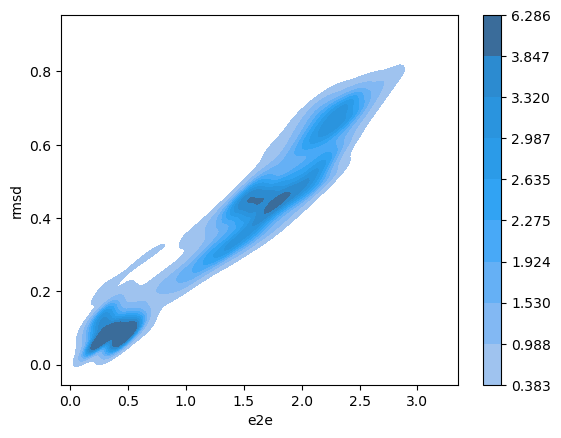

In [73]:
sns.kdeplot(data=colvar, x='e2e', y='rmsd', cbar=True, fill=True, )

# Write WT-METAD plumed simulation 

In [75]:
os.makedirs(base / 'data/interim' / mutate_name / 'wtmetad', exist_ok= True)
os.chdir(base / 'data/interim' / mutate_name / 'wtmetad')

In [166]:
# copy ref file 
shutil.copy2(fdir / 'MD/reference.pdb', './')
shutil.copy2(fdir / 'MD/md.tpr', './')
shutil.copy2(fdir / 'MD/md.pdb', './')
        


'./md.pdb'

In [168]:
# write plumed file for metadynamics simulation
with open('plumed_wtmetad.dat', 'w') as f:
    print("""
    # vim:ft=plumed
    # calculate  CVs for HLDA 
    MOLINFO STRUCTURE=reference.pdb MOLTYPE=protein
    WHOLEMOLECULES RESIDUES=all MOLTYPE=protein
    rmsd: RMSD REFERENCE=reference.pdb TYPE=OPTIMAL NOPBC
    e2e: DISTANCE ATOMS=@N-0,@O-9 NOPBC
    rg: GYRATION TYPE=RADIUS ATOMS=@back-0,@back-1,@back-2,@back-3,@back-4,@back-5,@back-6,@back-7,@back-8,@back-9 NOPBC

    # dihedrals
    psi0: TORSION ATOMS=@psi-0 NOPBC
    phi1: TORSION ATOMS=@phi-1 NOPBC
    psi1: TORSION ATOMS=@psi-1 NOPBC
    phi2: TORSION ATOMS=@phi-2 NOPBC
    psi2: TORSION ATOMS=@psi-2 NOPBC
    phi3: TORSION ATOMS=@phi-3 NOPBC
    psi3: TORSION ATOMS=@psi-3 NOPBC
    phi4: TORSION ATOMS=@phi-4 NOPBC
    psi4: TORSION ATOMS=@psi-4 NOPBC
    phi5: TORSION ATOMS=@phi-5 NOPBC
    psi5: TORSION ATOMS=@psi-5 NOPBC
    phi6: TORSION ATOMS=@phi-6 NOPBC
    psi6: TORSION ATOMS=@psi-6 NOPBC
    phi7: TORSION ATOMS=@phi-7 NOPBC
    psi7: TORSION ATOMS=@psi-7 NOPBC
    phi8: TORSION ATOMS=@phi-8 NOPBC
    psi8: TORSION ATOMS=@psi-8 NOPBC
    phi9: TORSION ATOMS=@phi-9 NOPBC

    # combine hlda cv
    COMBINE ...
    ARG={}
    COEFFICIENTS={} 
    PERIODIC=NO
    LABEL=comb1
    ... COMBINE

    # metadynamics
    metad: METAD ...
    ARG=comb1 SIGMA=0.1 HEIGHT=1.2 BIASFACTOR=15 PACE=500 GRID_MIN=-6.5 GRID_MAX=6.5 FILE=HILLS
    ...

       

    PRINT ...
    ARG=comb1,metad.bias,rmsd,e2e,rg,psi0,phi1,psi1,phi2,psi2,phi3,psi3,phi4,psi4,phi5,psi5,phi6,psi6,phi7,psi7,phi8,psi8,phi9
    FILE=COLVAR STRIDE=100
    ... PRINT
    
      
    """.format(
        ','.join(X.columns),
        ','.join(['{:.4f}'.format(i) for i in hlda_evects])
    ), file = f) 

## Run WT-METAD simulation

In [170]:
# simulate and collect CVs
# run on dgx-master
#run_mpi_slurm('gmx mdrun -v -deffnm md -cpi -ntomp 2  -pin on -plumed plumed.dat   -c md.pdb -nsteps {} '.format(NSTEPS),**system )

#run local
subprocess.run('export OMP_NUM_THREADS={} && gmx_mpi mdrun  -v -deffnm md -cpi -plumed plumed_wtmetad.dat  -c md.pdb -ntomp {} -nsteps {} -pin on '.format(NTHREADS, NTHREADS, NSTEPS), shell=True )


--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------
                      :-) GROMACS - gmx mdrun, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov 

No previous checkpoint file present with -cpi option, assuming this is a new run.


step 4999900, remaining wall clock time:     0 s          
Writing final coordinates.

Back Off! I just backed up md.pdb to ./#md.pdb.1#
step 5000000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)        (%)
       Time:   128831.176     4025.976     3200.0
                         1h07:05
                 (ns/day)    (hour/ns)
Performance:      214.606        0.112

GROMACS reminds you: "Push It Real Good" (Salt 'n' Pepa)



CompletedProcess(args='export OMP_NUM_THREADS=32 && gmx_mpi mdrun  -v -deffnm md -cpi -plumed plumed_wtmetad.dat  -c md.pdb -ntomp 32 -nsteps 5000000 -pin on ', returncode=0)

## calculate fes 

### Using plumed sum_hills 

In [172]:
# run plumed driver
kB = 8.31446261815324e-3
T=340
kBT = kB*T
subprocess.run(
    'export  PLUMED_NUM_THREADS={} && plumed sum_hills --hills=HILLS --kt={}  --mintozero  '.format(NTHREADS, kBT)
               , shell=True )


--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------


PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed
PLUMED: For installed feature, see /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 32
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Fi

CompletedProcess(args='export  PLUMED_NUM_THREADS=32 && plumed sum_hills --hills=HILLS --kt=2.826917290172102  --mintozero  ', returncode=0)

In [35]:
fes = plumed.read_as_pandas('fes.dat')
colvar = plumed.read_as_pandas('COLVAR')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/1169150500.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fes = plumed.read_as_pandas('fes.dat')
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/1169150500.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  colvar = plumed.read_as_pandas('COLVAR')


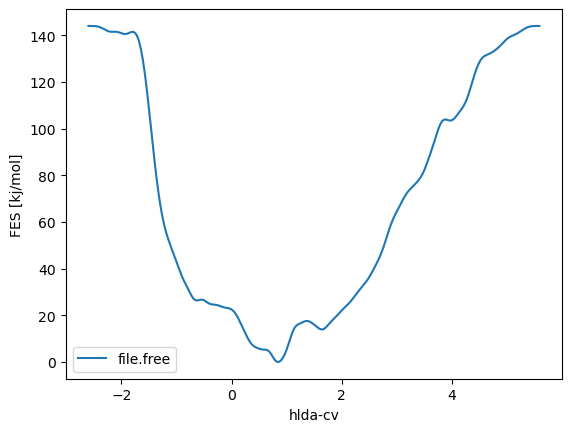

In [36]:
fes.plot(x='comb1', y='file.free')
plt.xlabel('hlda-cv')
plt.ylabel('FES [kj/mol]')
plt.show()

<Axes: xlabel='comb1', ylabel='rmsd'>

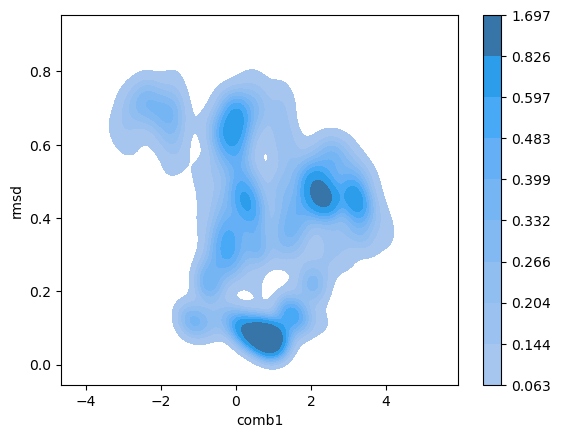

In [37]:
sns.kdeplot(data=colvar, x='comb1', y='rmsd', cbar=True, fill=True)

<Axes: xlabel='time'>

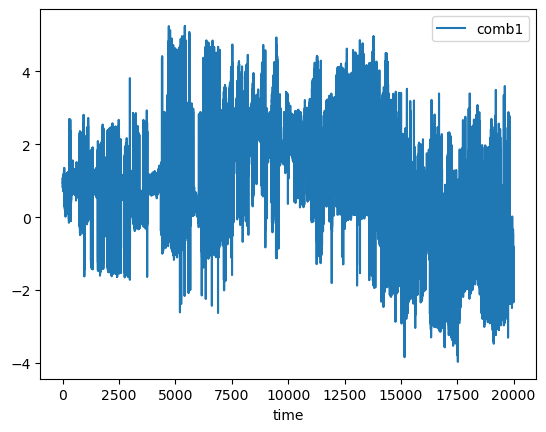

In [38]:
colvar.plot(x='time',y='comb1')

__Convergence - System is diffusing between states over the CV__

In [39]:
hills = plumed.read_as_pandas('HILLS')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/4083660326.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  hills = plumed.read_as_pandas('HILLS')


<Axes: xlabel='time'>

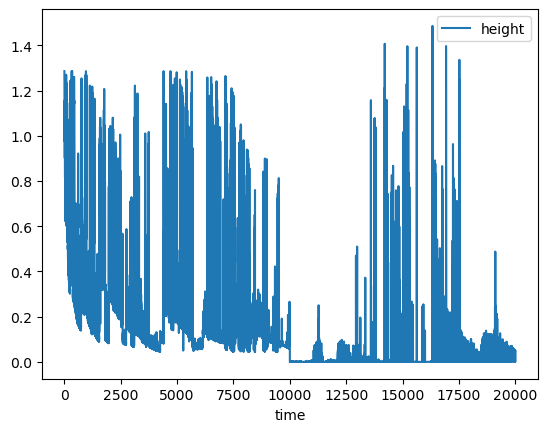

In [40]:
hills.plot(x='time', y='height')

### Using reweighting

In [78]:
# write plumed file for metadynamics simulation
with open('plumed_reweight.dat', 'w') as f:
    print("""
    # vim:ft=plumed
    # calculate  CVs for HLDA 
    MOLINFO STRUCTURE=reference.pdb MOLTYPE=protein
    WHOLEMOLECULES RESIDUES=all MOLTYPE=protein
    rmsd: RMSD REFERENCE=reference.pdb TYPE=OPTIMAL NOPBC
    e2e: DISTANCE ATOMS=@N-0,@O-9 NOPBC
    rg: GYRATION TYPE=RADIUS ATOMS=@back-0,@back-1,@back-2,@back-3,@back-4,@back-5,@back-6,@back-7,@back-8,@back-9 NOPBC

    # dihedrals
    psi0: TORSION ATOMS=@psi-0 NOPBC
    phi1: TORSION ATOMS=@phi-1 NOPBC
    psi1: TORSION ATOMS=@psi-1 NOPBC
    phi2: TORSION ATOMS=@phi-2 NOPBC
    psi2: TORSION ATOMS=@psi-2 NOPBC
    phi3: TORSION ATOMS=@phi-3 NOPBC
    psi3: TORSION ATOMS=@psi-3 NOPBC
    phi4: TORSION ATOMS=@phi-4 NOPBC
    psi4: TORSION ATOMS=@psi-4 NOPBC
    phi5: TORSION ATOMS=@phi-5 NOPBC
    psi5: TORSION ATOMS=@psi-5 NOPBC
    phi6: TORSION ATOMS=@phi-6 NOPBC
    psi6: TORSION ATOMS=@psi-6 NOPBC
    phi7: TORSION ATOMS=@phi-7 NOPBC
    psi7: TORSION ATOMS=@psi-7 NOPBC
    phi8: TORSION ATOMS=@phi-8 NOPBC
    psi8: TORSION ATOMS=@psi-8 NOPBC
    phi9: TORSION ATOMS=@phi-9 NOPBC

    # combine hlda cv
    COMBINE ...
    ARG={}
    COEFFICIENTS={} 
    PERIODIC=NO
    LABEL=comb1
    ... COMBINE

    # metadynamics, for reweight set height=0, pace=inf, and 
    metad: METAD ...
    ARG=comb1 SIGMA=0.1 HEIGHT=0.0 BIASFACTOR=15 PACE=500000000 GRID_MIN=-6.5 GRID_MAX=6.5 FILE=HILLS
    TEMP=340
    RESTART=YES
    ...

    # reweight bias
    rw_bias: REWEIGHT_BIAS ARG=metad.bias TEMP=340

    # histogram 

    hhh: HISTOGRAM ARG=comb1 LOGWEIGHTS=rw_bias STRIDE=1 GRID_MIN=-6.5 GRID_MAX=6.5 GRID_BIN=300 BANDWIDTH=0.02

    # convert to fes

    fff: CONVERT_TO_FES GRID=hhh TEMP=340 MINTOZERO

    # print
    DUMPGRID GRID=fff FILE=fes_rw.dat     

    # histogram over e2e,rmsd

    hhr: HISTOGRAM ARG=e2e,rmsd LOGWEIGHTS=rw_bias STRIDE=1 GRID_MIN=0,0 GRID_MAX=5,1 GRID_BIN=300,300 KERNEL=DISCRETE 

    # convert to fes

    ffr: CONVERT_TO_FES GRID=hhr TEMP=340 MINTOZERO

    # print
    DUMPGRID GRID=ffr FILE=fes2_rw.dat 
       

      
    """.format(
        ','.join(X.columns),
        ','.join(['{:.4f}'.format(i) for i in hlda_evects])
    ), file = f) 

In [79]:
# run plumed driver
subprocess.run(
    'export  PLUMED_NUM_THREADS={} && plumed driver --plumed=plumed_reweight.dat --mf_trr=md.trr'.format(NTHREADS)
               , shell=True )


--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------



DRIVER: Found molfile format trajectory trr with name md.trr
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed
PLUMED: For installed feature, see /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 32
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 5094
PLUMED: File suffix: 
PLUMED: FILE: plumed_reweight.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named reference.pdb contains 1 chains 
PLUMED:   chain named A contains residues 0 to 9 and atoms 1 to 166 
PLUMED: Action WHOLEMOLECULES
PLUMED:   with label @1
PLUMED:   with stride 1
PLUMED: WARNING for 

CompletedProcess(args='export  PLUMED_NUM_THREADS=32 && plumed driver --plumed=plumed_reweight.dat --mf_trr=md.trr', returncode=0)

In [50]:
fes_rw = plumed.read_as_pandas('fes_rw.dat')


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/52366540.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fes_rw = plumed.read_as_pandas('fes_rw.dat')


## Compare fes from two calculations

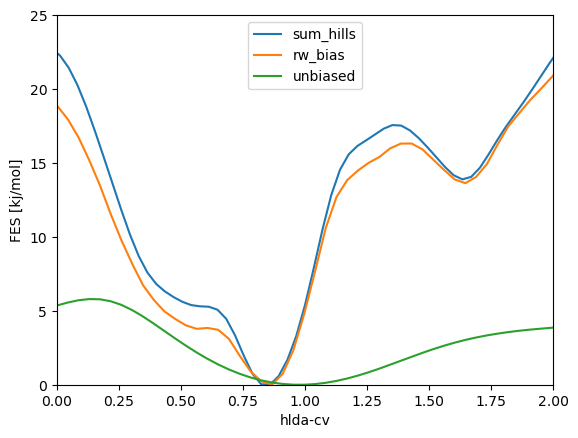

In [53]:
fig, ax = plt.subplots()
fes.plot(x='comb1', y='file.free', label='sum_hills', ax=ax)
fes_rw.plot(x='comb1', y='fff', label='rw_bias', ax=ax)
fes_unbiased.plot(x='comb1', y='fff', label='unbiased', ax=ax)
plt.xlabel('hlda-cv')
plt.ylabel('FES [kj/mol]')
plt.xlim([0,2])
plt.ylim([0,25])
plt.show()

## FES profile convergence

In [210]:
# run plumed driver
kB = 8.31446261815324e-3
T=340
kBT = kB*T
subprocess.run(
    'export  PLUMED_NUM_THREADS={} && plumed sum_hills --hills=HILLS --kt={}  --stride=500 '.format(NTHREADS, kBT)
               , shell=True )


--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------


PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed
PLUMED: For installed feature, see /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 32
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Fi

CompletedProcess(args='export  PLUMED_NUM_THREADS=32 && plumed sum_hills --hills=HILLS --kt=2.826917290172102  --stride=500 ', returncode=0)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1139793/4086868756.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = plumed.read_as_pandas('fes_{}.dat'.format(i))
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1139793/4086868756.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = plumed.read_as_pandas('fes_{}.dat'.format(i))
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1139793/4086868756.py:3: FutureWarning: Th

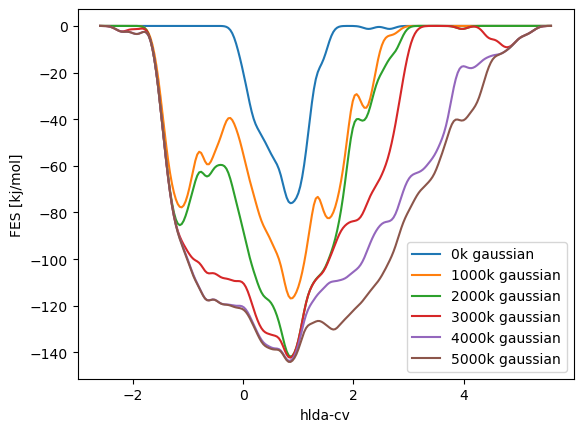

In [214]:
fig, ax = plt.subplots()
for i in range(0,21,4):
    tmp = plumed.read_as_pandas('fes_{}.dat'.format(i))
    tmp.plot(x='comb1', y='file.free', label='{:.0f}k gaussian'.format(i*500/2), ax=ax)

plt.xlabel('hlda-cv')
plt.ylabel('FES [kj/mol]')
plt.show()  

__Still unconverged - we will continue the simulation with a smaller bias factor__

In [215]:
# write plumed file for metadynamics simulation
with open('plumed_wtmetad_restart.dat', 'w') as f:
    print("""
    # vim:ft=plumed
    # calculate  CVs for HLDA 
    RESTART
    MOLINFO STRUCTURE=reference.pdb MOLTYPE=protein
    WHOLEMOLECULES RESIDUES=all MOLTYPE=protein
    rmsd: RMSD REFERENCE=reference.pdb TYPE=OPTIMAL NOPBC
    e2e: DISTANCE ATOMS=@N-0,@O-9 NOPBC
    rg: GYRATION TYPE=RADIUS ATOMS=@back-0,@back-1,@back-2,@back-3,@back-4,@back-5,@back-6,@back-7,@back-8,@back-9 NOPBC

    # dihedrals
    psi0: TORSION ATOMS=@psi-0 NOPBC
    phi1: TORSION ATOMS=@phi-1 NOPBC
    psi1: TORSION ATOMS=@psi-1 NOPBC
    phi2: TORSION ATOMS=@phi-2 NOPBC
    psi2: TORSION ATOMS=@psi-2 NOPBC
    phi3: TORSION ATOMS=@phi-3 NOPBC
    psi3: TORSION ATOMS=@psi-3 NOPBC
    phi4: TORSION ATOMS=@phi-4 NOPBC
    psi4: TORSION ATOMS=@psi-4 NOPBC
    phi5: TORSION ATOMS=@phi-5 NOPBC
    psi5: TORSION ATOMS=@psi-5 NOPBC
    phi6: TORSION ATOMS=@phi-6 NOPBC
    psi6: TORSION ATOMS=@psi-6 NOPBC
    phi7: TORSION ATOMS=@phi-7 NOPBC
    psi7: TORSION ATOMS=@psi-7 NOPBC
    phi8: TORSION ATOMS=@phi-8 NOPBC
    psi8: TORSION ATOMS=@psi-8 NOPBC
    phi9: TORSION ATOMS=@phi-9 NOPBC

    # combine hlda cv
    COMBINE ...
    ARG={}
    COEFFICIENTS={} 
    PERIODIC=NO
    LABEL=comb1
    ... COMBINE

    # metadynamics
    metad: METAD ...
    ARG=comb1 SIGMA=0.1 HEIGHT=1.2 BIASFACTOR=5 PACE=500 GRID_MIN=-6.5 GRID_MAX=6.5 FILE=HILLS
    ...

       

    PRINT ...
    ARG=comb1,metad.bias,rmsd,e2e,rg,psi0,phi1,psi1,phi2,psi2,phi3,psi3,phi4,psi4,phi5,psi5,phi6,psi6,phi7,psi7,phi8,psi8,phi9
    FILE=COLVAR STRIDE=100
    ... PRINT
    
      
    """.format(
        ','.join(X.columns),
        ','.join(['{:.4f}'.format(i) for i in hlda_evects])
    ), file = f) 

In [ ]:
# simulate and collect CVs restart - wtmetad simulation 

#run local
subprocess.run('export OMP_NUM_THREADS={} && gmx_mpi mdrun  -v -deffnm md -cpi -plumed plumed_wtmetad_restart.dat  -c md.pdb -ntomp {} -nsteps {} -pin on '.format(NTHREADS, NTHREADS, NSTEPS), shell=True )


--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------
                      :-) GROMACS - gmx mdrun, 2019.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov 

In [89]:
colvar = plumed.read_as_pandas('COLVAR')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/1593251216.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  colvar = plumed.read_as_pandas('COLVAR')


<Axes: xlabel='time'>

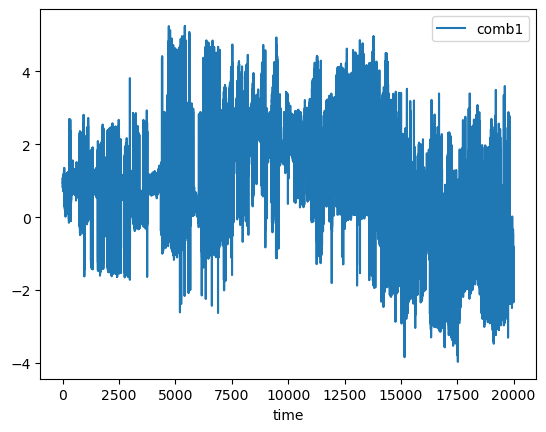

In [91]:
colvar.plot(x='time',y='comb1')

In [217]:
# run plumed driver
kB = 8.31446261815324e-3
T=340
kBT = kB*T
subprocess.run(
    'export  PLUMED_NUM_THREADS={} && plumed sum_hills --hills=HILLS --kt={}  --stride=500 '.format(NTHREADS, kBT)
               , shell=True )


--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------


PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed
PLUMED: For installed feature, see /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 32
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Fi

CompletedProcess(args='export  PLUMED_NUM_THREADS=32 && plumed sum_hills --hills=HILLS --kt=2.826917290172102  --stride=500 ', returncode=0)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1139793/3717061933.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = plumed.read_as_pandas('fes_{}.dat'.format(i))
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1139793/3717061933.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  tmp = plumed.read_as_pandas('fes_{}.dat'.format(i))
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1139793/3717061933.py:3: FutureWarning: Th

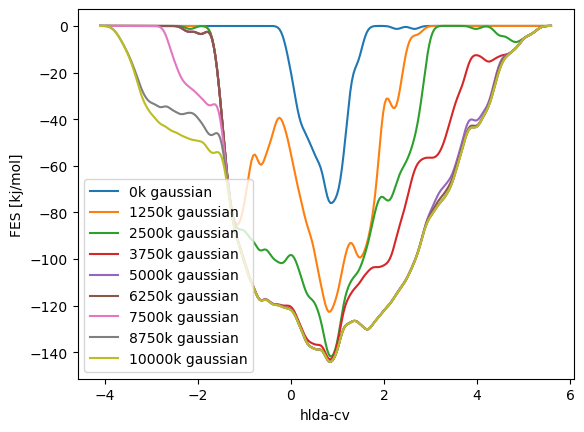

In [218]:
fig, ax = plt.subplots()
for i in range(0,41,5):
    tmp = plumed.read_as_pandas('fes_{}.dat'.format(i))
    tmp.plot(x='comb1', y='file.free', label='{:.0f}k gaussian'.format(i*500/2), ax=ax)

plt.xlabel('hlda-cv')
plt.ylabel('FES [kj/mol]')
plt.show()  

__Convergence - As gaussians are added we can see no significant change in the FES__

In [219]:
# run plumed driver
subprocess.run(
    'export  PLUMED_NUM_THREADS={} && plumed driver --plumed=plumed_reweight.dat --mf_trr=md.trr'.format(NTHREADS)
               , shell=True )


--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------



DRIVER: Found molfile format trajectory trr with name md.trr
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed
PLUMED: For installed feature, see /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 32
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 5094
PLUMED: File suffix: 
PLUMED: FILE: plumed_reweight.dat
PLUMED: Action MOLINFO
PLUMED:   with label @0
PLUMED:   pdb file named reference.pdb contains 1 chains 
PLUMED:   chain named A contains residues 0 to 9 and atoms 1 to 166 
PLUMED: Action WHOLEMOLECULES
PLUMED:   with label @1
PLUMED:   with stride 1
PLUMED: WARNING for 

CompletedProcess(args='export  PLUMED_NUM_THREADS=32 && plumed driver --plumed=plumed_reweight.dat --mf_trr=md.trr', returncode=0)

In [223]:
# run plumed driver
kB = 8.31446261815324e-3
T=340
kBT = kB*T
subprocess.run(
    'export  PLUMED_NUM_THREADS={} && plumed sum_hills --hills=HILLS --kt={}  --outfile fes_restart_hills.dat --mintozero'.format(NTHREADS, kBT)
               , shell=True )


--------------------------------------------------------------------------

  Local host:   n151
  Local device: mlx5_1
--------------------------------------------------------------------------


PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed
PLUMED: For installed feature, see /home/zadoki/miniforge3/envs/gromacs_plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 32
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Fi

CompletedProcess(args='export  PLUMED_NUM_THREADS=32 && plumed sum_hills --hills=HILLS --kt=2.826917290172102  --outfile fes_restart_hills.dat --mintozero', returncode=0)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/4031727668.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fes_restart_hills = plumed.read_as_pandas('fes_restart_hills.dat')
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/4031727668.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fes_restart_rw = plumed.read_as_pandas('fes_rw.dat')


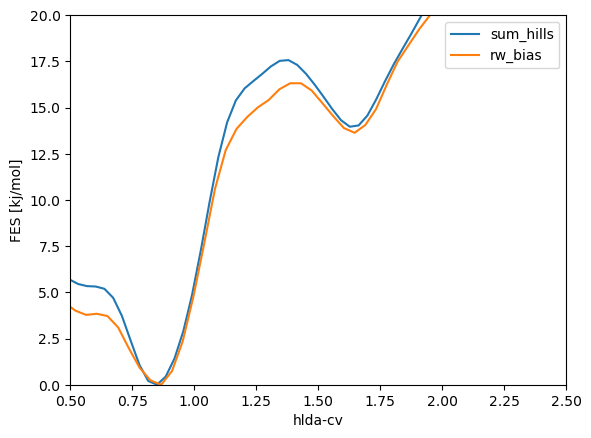

In [92]:
fes_restart_hills = plumed.read_as_pandas('fes_restart_hills.dat')
fes_restart_rw = plumed.read_as_pandas('fes_rw.dat')
fig, ax = plt.subplots()
fes_restart_hills.plot(x='comb1', y='file.free', label='sum_hills', ax=ax)
fes_restart_rw.plot(x='comb1', y='fff', label='rw_bias', ax=ax)
plt.xlabel('hlda-cv')
plt.ylabel('FES [kj/mol]')
plt.xlim([0.5,2.5])
plt.ylim([0,20])
plt.show()

__Convergence - FES are similar, reweighting is using a KDE so some data is smoothed__

In [80]:
fes2_rw = plumed.read_as_pandas('fes2_rw.dat')

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/zadoki/miniforge3/envs/gromacs_plumed/lib/libplumedKernel.so" +++
/gtmp/pbs.266095.zeus-master/ipykernel_1149023/844896887.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fes2_rw = plumed.read_as_pandas('fes2_rw.dat')


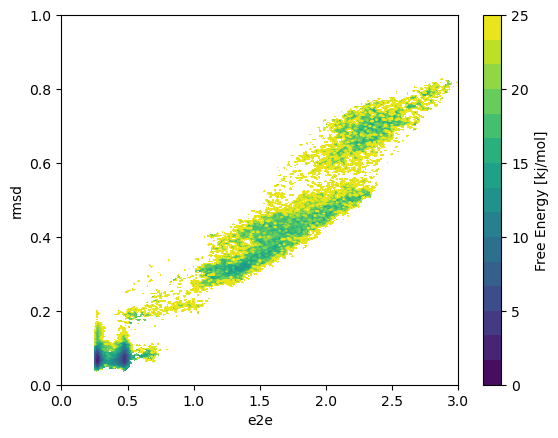

In [88]:
fig, ax = plt.subplots()
from matplotlib.cm import ScalarMappable
levels = 15
vmin = 0
vmax = 25
level_boundaries = np.linspace(vmin, vmax, levels + 1)

quadcontourset = ax.contourf(
    fes2_rw.e2e.to_numpy().reshape(301,301),
    fes2_rw.rmsd.to_numpy().reshape(301,301), 
    fes2_rw.ffr.to_numpy().reshape(301,301),
    level_boundaries,  
    vmin=vmin, vmax=vmax
)


fig.colorbar(
    ScalarMappable(norm=quadcontourset.norm, cmap=quadcontourset.cmap),
    ticks=range(vmin, vmax+5, 5),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
    ax=ax,
    label='Free Energy [kj/mol]'
)
plt.xlabel('e2e')
plt.ylabel('rmsd')
plt.xlim([0,3])
plt
plt.show()

## Another test -  $\Delta F$ convergence